# Function Optimization Demo

In [197]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
from jax import grad
from jax import vmap

import typing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Callable, Tuple, List

In [198]:
@jit
def himmelblau(x: jnp.ndarray) -> jnp.ndarray:
    x1, x2 = x[0], x[1]
    return (x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2

@jit
def rosenbrock(x: jnp.ndarray) -> jnp.ndarray:
    x1, x2 = x[0], x[1]
    return (1 - x1)**2 + 100 * (x2 - x1**2)**2

function = himmelblau

In [199]:
if function == himmelblau:
    accuracy = 1_000
    lower_bound = -5
    upper_bound = 5
else:
    accuracy = 1_000
    lower_bound = -3
    upper_bound = 3
x1 = jnp.linspace(lower_bound, upper_bound, accuracy)
x2 = jnp.linspace(lower_bound, upper_bound, accuracy)
X1, X2 = jnp.meshgrid(x1, x2)

Z = vmap(lambda x1, x2: function(jnp.array([x1, x2])))(X1, X2)

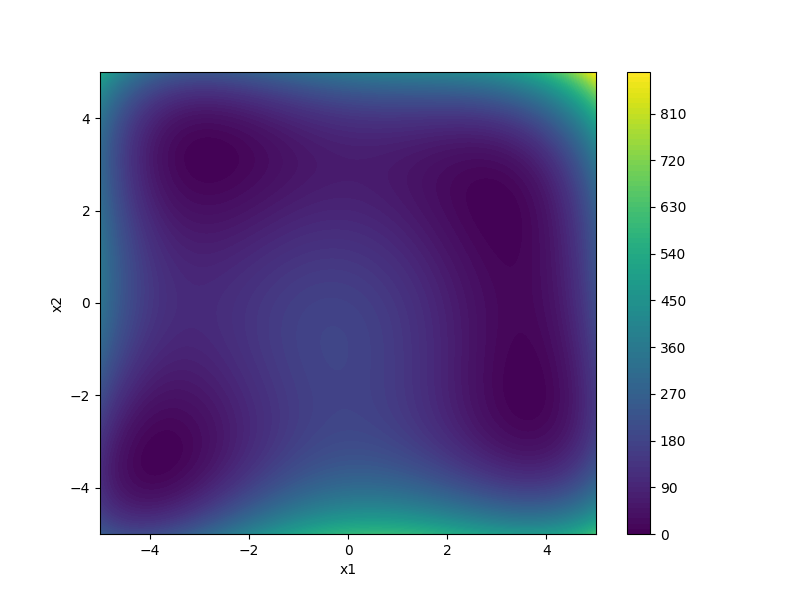

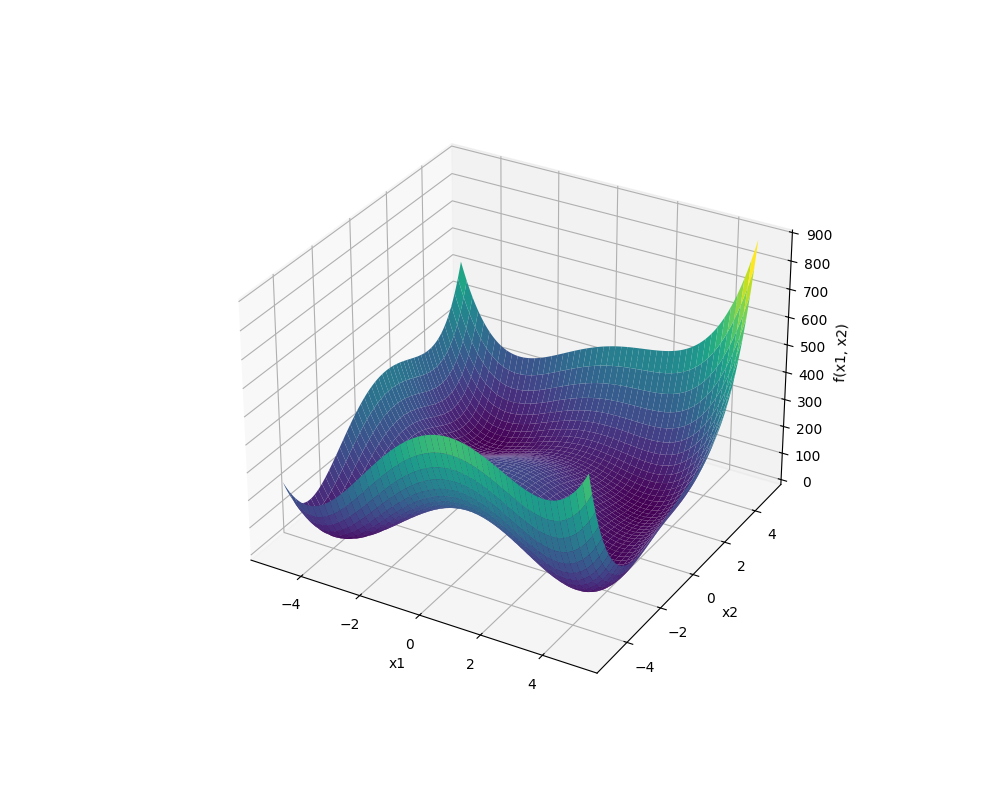

In [200]:
%matplotlib widget

def plot_2d(X: jnp.ndarray, Y: jnp.ndarray, Z: jnp.ndarray) -> None:
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, Z, levels=100, cmap='viridis')
    plt.colorbar()
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

def plot_3d(X: jnp.ndarray, Y: jnp.ndarray, Z: jnp.ndarray) -> None:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("f(x1, x2)")
    plt.show()
    
plot_2d(X1, X2, Z)
plot_3d(X1, X2, Z)

In [201]:
@jit
def gradient_descent_step(x: jnp.ndarray) -> jnp.ndarray:
    if function == himmelblau:
        learning_rate = 0.01
    else:
        learning_rate = 0.0005
    grad_f = grad(function)(x)
    return x - learning_rate * grad_f

@jit
def newton_step(x: jnp.ndarray) -> jnp.ndarray:
    if function == himmelblau:
        tau = 100
    else:
        tau = 10000
    grad_f = grad(function)(x)
    hess_f = jax.hessian(function)(x)
    hess_inv = jnp.linalg.inv(hess_f + tau * jnp.eye(len(x)))  # Adding a small value for numerical stability
    return x - hess_inv @ grad_f


def run_optimization(x_init: jnp.ndarray, step_function: Callable[[jnp.ndarray], jnp.ndarray]) -> jnp.ndarray:
    num_steps = 100
    history = [x_init]

    x = x_init
    for step in range(num_steps):
        x = step_function(x)
        history.append(x)

    return jnp.array(history)


In [202]:
# plot the optimization path
def plot_optimization_path(X: jnp.ndarray, Y: jnp.ndarray, Z: jnp.ndarray, history: jnp.ndarray) -> None:
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, Z, levels=100, cmap='viridis')
    plt.colorbar()
    plt.plot(history[:, 0], history[:, 1], color='red', marker='o', markersize=3, linewidth=1, label='Optimization Path')
    # mark the first point 
    plt.plot(history[0, 0], history[0, 1], color='white', marker='x', markersize=10, label='Start Point')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()

In [203]:
def plot_multiple_optimization_paths(X: jnp.ndarray, Y: jnp.ndarray, Z: jnp.ndarray, histories: List[jnp.ndarray], labels: List[str]) -> None:
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, Z, levels=100, cmap='viridis')
    plt.colorbar()
    
    for history, label in zip(histories, labels):
        plt.plot(history[:, 0], history[:, 1], marker='o', markersize=3, linewidth=1, label=label)
        
    plt.plot(histories[0][0, 0], histories[0][0, 1], marker='x', markersize=10, label=f'Start Point')
    
    # mark real minima
    if function == himmelblau:
        minima = jnp.array([[3.0, 2.0], [-2.805118, 3.131312], [-3.779310, -3.283186], [3.584428, -1.848126]])
        plt.scatter(minima[:, 0], minima[:, 1], color='white', marker='*', s=200, label='Real Minima')
    elif function == rosenbrock:
        plt.scatter(1.0, 1.0, color='white', marker='*', s=200, label='Real Minimum')
    
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()
    
def plot_multiple_3d_optimization_paths(X: jnp.ndarray, Y: jnp.ndarray, Z: jnp.ndarray, histories: List[jnp.ndarray], labels: List[str]) -> None:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)
    
    for history, label in zip(histories, labels):
        Z_history = vmap(himmelblau)(history)
        ax.plot(history[:, 0], history[:, 1], Z_history, marker='o', markersize=3, linewidth=1, label=label)
        # mark the first point 
        ax.plot([history[0, 0]], [history[0, 1]], [Z_history[0]], marker='x', markersize=10)
    
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("f(x1, x2)")
    ax.legend()
    plt.show()

In [204]:
master_key = random.PRNGKey(0)

Gradient Descent Steps: 101
Newton's Method Steps: 101


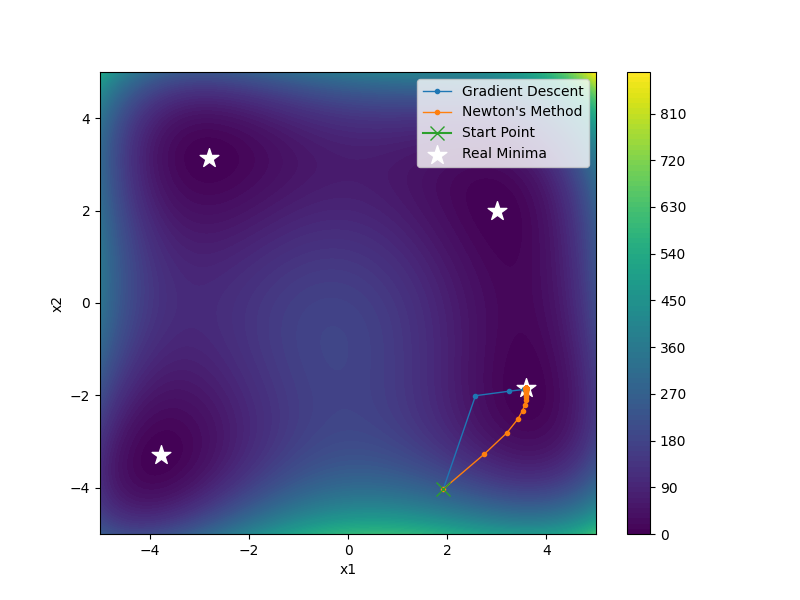

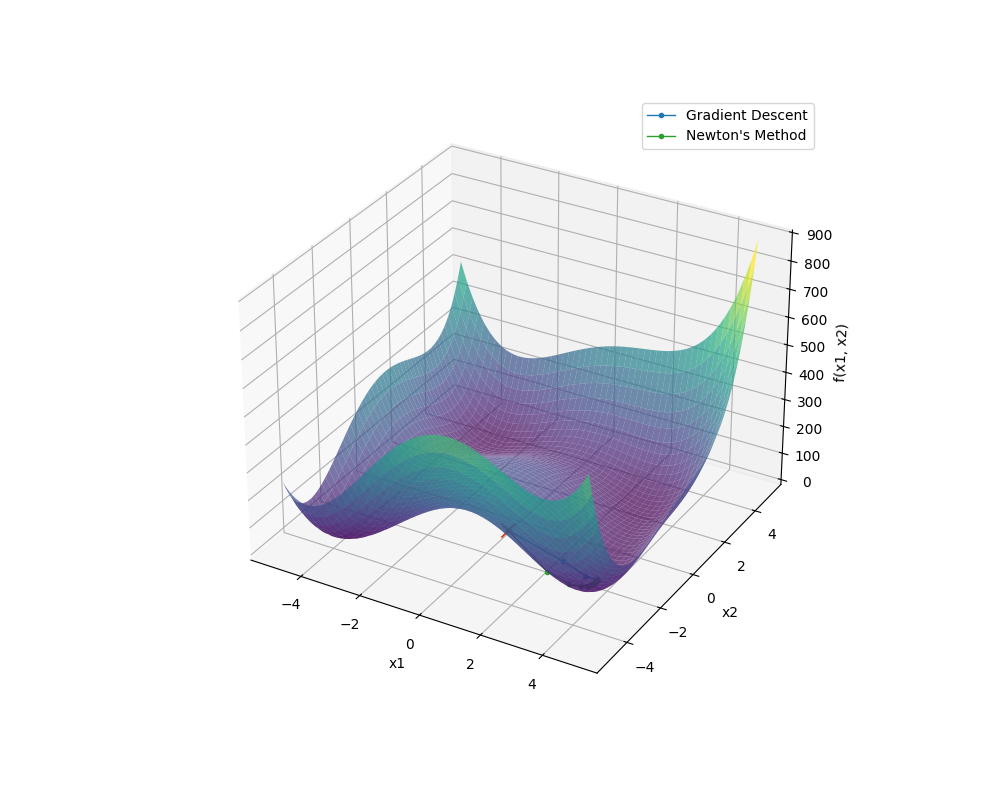

In [210]:
key, subkey = random.split(master_key)
x_init = random.uniform(key, shape=(2,), minval=lower_bound, maxval=upper_bound)

gradient_descent_history = run_optimization(x_init, gradient_descent_step)
newton_history = run_optimization(x_init, newton_step)

# print steps
print("Gradient Descent Steps:", gradient_descent_history.shape[0])
print("Newton's Method Steps:", newton_history.shape[0])

plot_multiple_optimization_paths(
    X1, X2, Z,
    [gradient_descent_history, newton_history],
    ['Gradient Descent', 'Newton\'s Method']
)

plot_multiple_3d_optimization_paths(
    X1, X2, Z,
    [gradient_descent_history, newton_history],
    ['Gradient Descent', 'Newton\'s Method']
)

master_key = subkey